# Pareto Optimality Under Uncertainty

Now that we know what Pareto optimality is and that there's a tool to efficiently perform MOO, we have to face another problem: such undertaking is computationally expensive -- for large-scale real-world numerical model, one such forward run could take hours, let alone hundreds of thousand of runs required in MOO.

For this tutorial, we will demonstrate how we can speed up the process of MOO by using a surrogate model, without compromising the reliability of solutions. We will still be using the 2D modified Kursawe problem.

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyemu


In [2]:
def kursawe_2d(x):
    x = np.array(x)
    obj1 = -10 * np.exp(-0.2 * np.sqrt(x[0]**2 + x[1]**2))
    obj2 = np.abs(x[0])**0.8 + 5 * np.sin(x[0]**3) + np.abs(x[1])**0.8 + 5 * np.sin(x[1]**3)
    return obj1, obj2

n_samples = 100
x1_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x2_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x1, x2 = np.meshgrid(x1_range, x2_range)
x1 = x1.flatten()
x2 = x2.flatten()

x1 = x1[:n_samples]
x2 = x2[:n_samples]

n_actual = min(len(x1), len(x2))
objectives = np.array([kursawe_2d([x1[i], x2[i]]) for i in range(n_actual)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]

Let us first generate the template files we need.

In [4]:
base_d = "./demo_files/kursawe2d"
assert os.path.exists(base_d)

temp_d = "kursawe2d_demo"
if os.path.exists(temp_d):
    shutil.rmtree(temp_d)
shutil.copytree(base_d,temp_d)

'kursawe2d_demo'

We can easily find Pareto optimal set of decision variables by running PESTPP-MOU. Let's generate an initial swarm size of 20 and perform 20 iterations of MOO. To ensure that our initial population is evenly distributed and sufficiently samples the decision space, it is advisable to use Latin Hypercube Sampling (LHS).

In [ ]:
# You can change the size of initial sample or the number of inner iterations if you want to try other values. 
# Just be aware that larger sample size and more inner iterations will take longer time to run.
swarm_size = 20
nmax_inner = 20

sys.path.append('./bin')
from LHS_sampler import generate_lhsstarter
bounds = np.array([[-5, 5] for i in range(2)])
generate_lhsstarter(os.path.join(temp_d,'kursawe2d_pbm_template'), seed=42, n_samples=swarm_size, n_dimensions=2, bounds=bounds) 

pst_file = os.path.join(temp_d, 'kursawe2d_pbm_template', 'kur.pst')
pst = pyemu.Pst(pst_file)
pst.pestpp_options['mou_population_size'] = swarm_size
pst.pestpp_options['mou_dv_population_file'] = 'starter.dv_pop.csv'
pst.control_data.noptmax = nmax_inner
pst.write(os.path.join(temp_d, 'kursawe2d_pbm_template', os.path.basename(pst_file)))

starter_pop = pd.read_csv(os.path.join(temp_d, "kursawe2d_pbm_template", "starter.dv_pop.csv"), index_col="real_name")
starter_pop.head()

noptmax:20, npar_adj:2, nnz_obs:2


,x1,x2
real_name,,
gen=0_member=0,-2.900058,2.001396
gen=0_member=1,-1.283856,2.516370
gen=0_member=2,2.938901,3.057931
gen=0_member=3,0.581404,-0.445164
gen=0_member=4,3.307439,-4.730684


Now that we have generated an initial population, let us run pestpp-mou...

In [6]:
num_workers = 8
tmpl_in = os.path.join(temp_d, "kursawe2d_pbm_template")
sys.path.insert(0,tmpl_in)
from forward_pbrun import ppw_worker as ppw_function
pyemu.os_utils.start_workers(tmpl_in, "../../bin/pestpp-mou", "kur.pst", num_workers = num_workers,
                             worker_root = temp_d, master_dir = os.path.join(temp_d, "pbm_run"),
                             ppw_function = ppw_function)
sys.path.remove(tmpl_in)

Let's plot the resulting front.

In [ ]:
from ipywidgets import interact, IntSlider, HBox, VBox, Output
from IPython.display import display
from scipy.interpolate import griddata
import glob
import matplotlib.pyplot as plt

run_data = pd.read_csv(os.path.join(temp_d, "pbm_run", "kur.pareto.summary.csv"))
max_gen = max(run_data['generation'])

csvfiles = sorted(glob.glob(os.path.join(temp_d, "pbm_run", "*[0-999].dv_pop.csv"), recursive=True), 
                  key=lambda x: int(x.split(".dv")[0].split(".")[1]))
all_dv_list = []
for file in csvfiles:
    generation = int(file.split(".dv")[0].split(".")[1])
    df = pd.read_csv(file).assign(generation=generation)
    df = df[['generation'] + [col for col in df.columns if col != 'generation']] 
    all_dv_list.append(df)
all_dv = pd.concat(all_dv_list, ignore_index=True)

csvfiles = sorted(glob.glob(os.path.join(temp_d, "pbm_run", "*[0-999].obs_pop.csv"), recursive=True), 
                      key=lambda x: int(x.split(".obs")[0].split(".")[1]))

all_obs_list = []
for file in csvfiles:
    generation = int(file.split(".obs")[0].split(".")[1])
    df = pd.read_csv(file).assign(generation=generation)
    df = df[['generation'] + [col for col in df.columns if col != 'generation']] 
    all_obs_list.append(df)
all_obs = pd.concat(all_obs_list, ignore_index=True)

all_data = pd.merge(all_dv, all_obs, on=['generation', 'real_name'])
max_gen = max(all_data['generation'])

n_samples = 100
x1_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x2_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x1, x2 = np.meshgrid(x1_range, x2_range)
x1 = x1.flatten()
x2 = x2.flatten()

x1 = x1[:n_samples]
x2 = x2[:n_samples]

n_actual = min(len(x1), len(x2))
objectives = np.array([kursawe_2d([x1[i], x2[i]]) for i in range(n_actual)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]

xi = np.linspace(min(x1), max(x1), n_samples)
yi = np.linspace(min(x2), max(x2), n_samples)
xi_grid, yi_grid = np.meshgrid(xi, yi)
zi1 = griddata((x1, x2), obj1, (xi_grid, yi_grid), method='cubic')
zi2 = griddata((x1, x2), obj2, (xi_grid, yi_grid), method='cubic')

out_pareto = Output()
out_contour = Output()

true_pareto = pd.read_csv(os.path.join('kursawe2d_demo', 'kursawe2d_solution_obj.csv'))

def moo_plot_all(generation):
    with out_pareto:
        out_pareto.clear_output(wait=True)
        pareto = run_data.loc[(run_data['generation']==generation) & (run_data['nsga2_front'] == 1)]
        plt.figure(figsize=(5, 5))
        plt.scatter(pareto['obj1'], pareto['obj2'], c='firebrick', s=20, zorder = 10, label = 'current non-dominated positions')
        plt.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s=10, zorder = -10, label='Pareto optimal solutions')

        all_points = run_data.loc[(run_data['generation']==generation)]
        plt.scatter(all_points['obj1'], all_points['obj2'], edgecolor='green', c = 'none', s=30, label = 'all candidate positions')
        
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.xlim((-10.5, -2))
        plt.ylim((-10, 15))
        plt.legend()
        plt.title(f'Pareto Front at Generation {generation}')
        plt.tight_layout()
        plt.show()
generation_slider = IntSlider(min=0, max=max_gen, step=1, value=max_gen, 
                             description='Generation:',
                             continuous_update=False)
moo_plot_all(max_gen)

generation_slider.observe(lambda change: moo_plot_all(change['new']), names='value')
display(VBox([
    generation_slider,
    HBox([out_pareto]),
    out_contour
]))


Use the slider to observe how the swarm's position and the front evolve at each iteration. We will revisit this later to compare with SAMOO, which will be introduced in Part 3 of this tutorial. This will be referred to as "Complex MOO" run.

As this benchmark is not too complex, it doesn't take much time to complete one iteration and it doesn't take a lot of iteration to obtain a set of Pareto optimal solutions. However, in reality, real-world models do not run this fast. Even with parallelisation, it can take a few hundred, even thousand iterations until the swarm converges to the Pareto front. If important timely decisions rely on the outcome of such optimisation process, we would need some help to speed up this process. 

Let's pretend for a while that the modified Kursawe problem is a complex model that is computationally expensive to evaluate. There's nothing much we could do about the run time of the complex model. What we can do is to employ an "emulator", a faster and cheaper model that approximates the relationships between the known (i.e., previously evaluated) input and outputs of the complex model in order to predict its response to some input values that were not previously evaluated. This emulator is also known as the **surrogate model**. Because the surrogate model is an approximation, its prediction has errors. These errors could mislead the decision-making to some suboptimal solutions that are not actually in the Pareto front. This is some price to pay for speeding up the process, but don't worry as we have means to manage these uncertainties and still obtain truly Pareto optimal solutions.

There are many surrogate models available in literature, but we will use Gaussian Process Regression (GPR) as it provides a convenient way quantify the uncertainty in predictions of the surrogate model, which, as previously said, needs to be managed well. There are many GPR tools but we will use local approximate GP (laGP) - it is originally an R package, but for easier integration in our algorithm, we will use the python implementation called laGPy.

Let's take a quick detour to see how GPR works. Here's a nonlinear function with 1D input and output. We generate, say 10, randomly generated values from within the bounds of the decision variable, and evaluate them in the nonlinear function. We then use the input-output pairs, or the **training dataset**, to "train" the GPR that can be used to predict the output of the nonlinear function at some other input values.

In [9]:
import matplotlib.pyplot as plt
import laGPy as gpr
import ipywidgets as widgets
from IPython.display import display, clear_output

def test_function(x):
    return np.sin(x) * np.exp(-0.2 * np.abs(x)) + 0.5 * np.cos(2 * x)

def update_plot(no_of_training_points):
    np.random.seed(5)
    X_train = np.sort(np.random.uniform(-10, 10, no_of_training_points))
    y_train = test_function(X_train)

    X_test = np.linspace(-10, 10, 10)
    mean_pred = np.zeros(len(X_test))
    std_pred = np.zeros(len(X_test))

    for i in range(len(X_test)):
        X_row = np.array([[X_test[i]]])
        sims = gpr.laGP(Xref=X_row, X=X_train.reshape(-1, 1), Z=y_train, start=6, end=9, verb=0)
        mean_pred[i] = sims['mean'].item()
        std_pred[i] = np.sqrt(sims['s2'].item())
    plt.figure(figsize=(10, 4))
    plt.scatter(X_train, y_train, color='red', label='Training points', s=20, zorder = 10)
    plt.scatter(X_test, mean_pred, color='blue', marker='o', label='Mean prediction at some tried points')

    X = np.linspace(-10, 10, 100)
    Y = test_function(X)
    plt.plot(X, Y, color='k', alpha=0.5, label='True function')
    min_idx = np.argmin(Y)
    min_x, min_y = X[min_idx], Y[min_idx]
    plt.scatter(min_x, min_y, color='red', marker='X', s=80, zorder=15, label=f'global minimum (x={min_x:.2f}, y={min_y:.2f})')
    
    mean_pred = np.zeros(len(X))
    std_pred = np.zeros(len(X))
    for i in range(len(X)):
        X_row = np.array([[X[i]]])
        sims = gpr.laGP(Xref=X_row, X=X_train.reshape(-1, 1), Z=y_train, start=6, end=9, verb=0)
        mean_pred[i] = sims['mean'].item()
        std_pred[i] = np.sqrt(sims['s2'].item())
    plt.plot(X, mean_pred, color='orange', label='Emulated function')
    emul_min_idx = np.argmin(mean_pred)
    emul_min_x, emul_min_y = X[emul_min_idx], mean_pred[emul_min_idx]
    plt.scatter(emul_min_x, emul_min_y, color='g',marker='+', s=60, zorder=15, label=f'emulated minimum (x={emul_min_x:.2f}, y={emul_min_y:.2f})')

    plt.fill_between(X, mean_pred - std_pred, mean_pred + std_pred, color='grey', alpha=0.2, label='$\\pm 1$ s.d.', zorder=-10)
    plt.fill_between(X, mean_pred - 2*std_pred, mean_pred + 2*std_pred, color='grey', alpha=0.15, label='$\\pm 2$ s.d.', zorder=-20)
    plt.fill_between(X, mean_pred - 3*std_pred, mean_pred + 3*std_pred, color='grey', alpha=0.1, label='$\\pm 3$ s.d.', zorder=-30)

    plt.xlabel('Input (x)')
    plt.ylabel('Output (y)')
    plt.ylim((-1.5, 1.5))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

training_points_slider = widgets.IntSlider(value=10, min=10, max=30, step=1, description='Training Dataset Size:', continuous_update=False)
output = widgets.Output()
with output:
    update_plot(training_points_slider.value)
def on_change(change):
    with output:
        clear_output(wait=True)
        update_plot(change['new'])
training_points_slider.observe(on_change, names='value')
display(widgets.VBox([training_points_slider, output]))

The correctness of GPR prediction depends on the amount of data it is trained with. Try increasing the size of the training dataset in the plot above and see how the emulated function becomes more like the true function. Bigger training dataset size is, of course, ideal but computationally expensive as they are evaluated in the complex model (the nonlinear function, in this case, is the expensive groundwater model in real-world problems). It is more practical to start with a manageable training dataset size and, using the GPR, find informative points (we will call them "infills") to be evaluated in the complex model which will subsequently be added to the training dataset. These informative points are such that will inform the optimisation process of the probable location of the global optimum (i.e., they need not be the global optimum initially, but will eventually converge there). 

Suppose we set the initial training dataset to 10 and we wanted to minimise the function, notice how the emulated minimum is far from the global minimum. Also note that the mean of the emulation does not go all the way down to the global minimum, but it is within 3 standard deviations. As we increase the training dataset size, the uncertainties are reduced. The informative points that we wanted are those that will significantly reduce the uncertainty especially around the global minimum, so the GPR can accurately predict it. More about this will be demonstrated in Part 3 of this tutorial.

Now, let's circle back to the original MOO problem. If we are starting with a few training points and emulate the objective functions, we have to deal with uncertainties in the prediction as illustrated below.

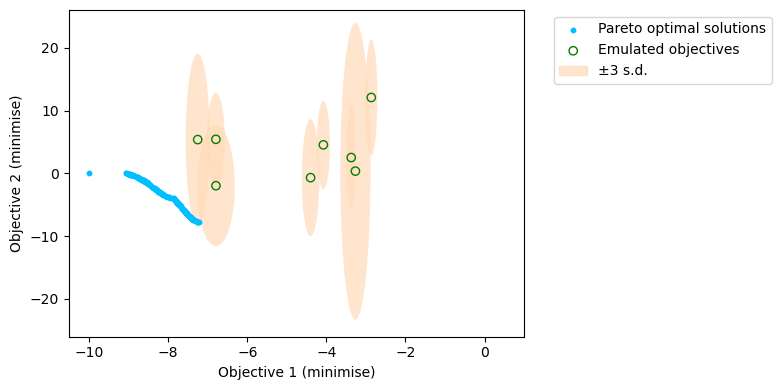

In [13]:
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipsoid(x, y, ax, fc = 'peachpuff'):
    width, height = 2 * 3.0 * x, 2 * 3.0 * y
    ellipse = Ellipse((0, 0), width=width, height=height, fc= fc, ec = 'none', zorder = -20, alpha = 0.70)
    transf = transforms.Affine2D().translate(0, 0)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def emulate_obj(Xref, X, Z1, Z2):
    obj1 = gpr.laGP(Xref=Xref, X=X, Z=Z1, start = 6, end = 10, verb=0)
    obj2 = gpr.laGP(Xref=Xref, X=X, Z=Z2, start = 6, end = 10, verb=0)
    return obj1, obj2

no_of_training_points = 50 #number of training points to train the GPR with

np.random.seed(5)
x_train = np.random.uniform(-5, 5, (no_of_training_points, 2))
x1_train = x_train[:, 0]  
x2_train = x_train[:, 1] 

objectives = np.array([kursawe_2d(x_train[i]) for i in range(no_of_training_points)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]

no_emu_points = 8 #number of emulated points
x_sample = np.random.uniform(-5, 5, (no_emu_points, 2))  # 2D array with 50 rows and 2 columns
x1_sample = x_sample[:, 0]  
x2_sample = x_sample[:, 1]  

obj1_mean = np.zeros(no_emu_points)
obj1_sd = np.zeros(no_emu_points)
obj2_mean = np.zeros(no_emu_points)
obj2_sd = np.zeros(no_emu_points)

for i in range(no_emu_points):
    x_row = x_sample[i].reshape(1,-1)
    sims1, sims2 = emulate_obj(x_row, x_train, obj1, obj2)
    obj1_mean[i] = sims1['mean'].item()
    obj1_sd[i] = np.sqrt(sims1['s2'].item())
    obj2_mean[i] = sims2['mean'].item()
    obj2_sd[i] = np.sqrt(sims2['s2'].item())

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s=10, zorder=-10, label='Pareto optimal solutions')

ax1.scatter(obj1_mean, obj2_mean, ec='g', c='none', label='Emulated objectives')
for i in range(no_emu_points):
    confidence_ellipsoid(obj1_sd[i], obj2_sd[i], ax1).set_center((obj1_mean[i], obj2_mean[i]))

# Set labels and title
ax1.set_xlabel('Objective 1 (minimise)')
ax1.set_ylabel('Objective 2 (minimise)')
peach_patch = mpatches.Patch(color='peachpuff', alpha=0.7, label='±3 s.d.')
ax1.legend(handles=[*ax1.get_legend_handles_labels()[0], peach_patch], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


 These uncertainties will affect the dominance relationship between objective positions. Let's take a closer look at the dominance relationship between two emulated objectives:

In [21]:
from ipywidgets import interact
from scipy.stats import norm

def emulate_obj(Xref, X, Z1, Z2):
    obj1 = gpr.laGP(Xref=Xref, X=X, Z=Z1, start = 6, end = 10, verb=0)
    obj2 = gpr.laGP(Xref=Xref, X=X, Z=Z2, start = 6, end = 10, verb=0)
    return obj1, obj2

def compute_pd(pos1_obj1, pos1_obj2, pos2_obj1, pos2_obj2):
    pd = norm.cdf((pos2_obj1['mean'] - pos1_obj1['mean']) / np.sqrt(np.sqrt(pos1_obj1['s2'])*2 + np.sqrt(pos2_obj1['s2'])**2))
    pd *= norm.cdf((pos2_obj2['mean'] - pos1_obj2['mean']) / np.sqrt(np.sqrt(pos1_obj2['s2'])*2 + np.sqrt(pos2_obj2['s2'])**2))
    return pd

no_of_training_points = 30

np.random.seed(5)
x_train = np.random.uniform(-5, 5, (no_of_training_points, 2))
x1_train = x_train[:, 0]  
x2_train = x_train[:, 1] 

objectives = np.array([kursawe_2d(x_train[i]) for i in range(no_of_training_points)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]

def update_plot(x1_new, x2_new):
    plt.clf()
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    sims1a, sims2a = emulate_obj(np.array([[0.2, 0.4]]), x_train, obj1, obj2)
    # ax1.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s=10, zorder=-10, label='Pareto optimal solutions')    
    ax1.scatter(sims1a['mean'].item(), sims2a['mean'].item(), ec='g', c='none', label='Emulated objectives')
    confidence_ellipsoid(np.sqrt(sims1a['s2'].item()), np.sqrt(sims2a['s2'].item()), ax1, fc = 'lightcoral').set_center((sims1a['mean'].item(), sims2a['mean'].item()))
    
    x_row = np.array([[x1_new, x2_new]])
    p1o1, p1o2 = emulate_obj(x_row, x_train, obj1, obj2)
    new_obj1_mean = p1o1['mean'].item()
    new_obj1_sd = np.sqrt(p1o1['s2'].item())
    new_obj2_mean = p1o2['mean'].item()
    new_obj2_sd = np.sqrt(p1o2['s2'].item())
    
    ax1.scatter(new_obj1_mean, new_obj2_mean, ec='r', c='none', s=40, label='Your input (emulated)')
    confidence_ellipsoid(new_obj1_sd, new_obj2_sd, ax1).set_center((new_obj1_mean, new_obj2_mean))
    
    rect_width = -2- new_obj1_mean 
    rect_height = 20 - new_obj2_mean
    rect = plt.Rectangle((new_obj1_mean, new_obj2_mean), rect_width, rect_height, 
                         color='grey', alpha=0.2, label = 'conventional dominance region')
    plt.gca().add_patch(rect)

    ax1.set_xlabel('Objective 1 (minimise)')
    ax1.set_ylabel('Objective 2 (minimise)')
    plt.xlim((-10, -2))
    plt.ylim((-15, 20))
    peach_patch = mpatches.Patch(color='peachpuff', alpha=0.7, label='±3 s.d.')
    ax1.legend(handles=[*ax1.get_legend_handles_labels()[0], peach_patch], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    prob_dom_red = compute_pd(p1o1, p1o2, sims1a, sims2a)
    prob_dom_grn = compute_pd(sims1a, sims2a, p1o1, p1o2)

    ax1.annotate(
        f"Objectives (mean ± 3 s.d.)\nat trial point ({x1_new:.2f}, {x2_new:.2f}):\n"
        f"obj1 = {new_obj1_mean:.4f} ± {3 * new_obj1_sd:.4f}\n"
        f"obj2 = {new_obj2_mean:.4f} ± {3 * new_obj2_sd:.4f}\n \n"
        f"prob(red dom. green) = {prob_dom_red.item():.4f}\n"
        f"prob(green dom. red) = {prob_dom_grn.item():.4f}",
        xy=(1.05, 0.5),
        xycoords='axes fraction',
        va='center',
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
    )


x1_slider = widgets.FloatSlider(value=-0.60, min=-5.0, max=5.0, step=0.1, description='x1:', continuous_update=False)
x2_slider = widgets.FloatSlider(value=0.40, min=-5.0, max=5.0, step=0.1, description='x2:', continuous_update=False)

interact(update_plot, x1_new=x1_slider, x2_new=x2_slider)

interactive(children=(FloatSlider(value=-0.6, continuous_update=False, description='x1:', max=5.0, min=-5.0), …

<function __main__.update_plot(x1_new, x2_new)>

Under the conventional definition of dominance, the red position would have dominated the green position. However, acknowledging that green is uncertain (because it is emulated -- for now, the only source of uncertainty that we consider is the GPR emulation) and it's true value could be anywhere in its ellipsoid, there is some chance that green may dominate red. If we use the traditional dominance criteria in the optimisation and green turned out to be informative, it could have been eliminated (this will be more clearly observed in Part 3 of this tutorial. Our focus for now is to demonstrate Pareto Dominance Under Uncertainty) from the set of infills.

We can compute the probability of one objective position dominating the other position -- the Probability of Dominance (PD). This has also been computed and shown above. Using PD, we introduce the probabilistic Pareto dominance (PPD) concept: considering the uncertainty of emulated position A, we can only say that it is probable to dominate another emulated position B, if PD of A dominating B exceeds a value $\beta$, which ideally is set between 0.5-0.70. In the example above, if we set $\beta$ to be 0.50, neither red nor green has significant probability of dominating each other; thus, they are both kept in the set of non-dominated solutions. Try moving the red position around and observe PD values.

Let's have a look at how this plays out with an entire population in an MOO iteration.

In [40]:
from ipywidgets import interact, FloatSlider, IntSlider, Checkbox, VBox, HBox, RadioButtons
sys.path.append('./bin')
from LHS_sampler import LatinHypercube
from nondomsort_utils import dominance_eval, first_dom_second, get_non_dominated_points

def interactive_ppd_plot(beta=0.50, use_ppd=True, ignore_unc=False, show_ellipsoids='none'):
    np.random.seed(5)
    no_of_training_points = 20
    x_train = np.random.uniform(-5, 5, (no_of_training_points, 2))
    x1_train = x_train[:, 0]  
    x2_train = x_train[:, 1] 

    objectives = np.array([kursawe_2d(x_train[i]) for i in range(no_of_training_points)])
    obj1 = objectives[:, 0]
    obj2 = objectives[:, 1]

    bounds = np.array([[-5, 5] for i in range(2)])
    n_samples = 50
    lhs = LatinHypercube(n_samples=n_samples, n_dimensions=2)
    samples = lhs.sample(method='maximin', bounds=bounds, iterations=1000)

    obj1_pred = np.zeros(n_samples, dtype=[('mean', float), ('s2', float)])
    obj2_pred = np.zeros(n_samples, dtype=[('mean', float), ('s2', float)])

    for i in range(n_samples):
        xrow_i = samples[i].reshape(1, -1)
        obj1_i, obj2_i = emulate_obj(xrow_i, x_train, obj1, obj2)
        
        obj1_pred[i]['mean'] = obj1_i['mean'].item()
        obj2_pred[i]['mean'] = obj2_i['mean'].item() 

        if ignore_unc:
            obj1_pred[i]['s2'] = 0
            obj2_pred[i]['s2'] = 0
        else:
            obj1_pred[i]['s2'] = obj1_i['s2'].item()
            obj2_pred[i]['s2'] = obj2_i['s2'].item()
        
    if use_ppd:
        non_dominated_indices = get_non_dominated_points(obj1_pred, obj2_pred, beta, n_samples)
    else:
        means_only = np.column_stack(([obj1_pred[i]['mean'] for i in range(n_samples)], [obj2_pred[i]['mean'] for i in range(n_samples)]))
        non_dominated_indices = []
        for i in range(n_samples):
            is_dominated = False
            for j in range(n_samples):
                if i != j and means_only[j, 0] <= means_only[i, 0] and means_only[j, 1] <= means_only[i, 1] and \
                   (means_only[j, 0] < means_only[i, 0] or means_only[j, 1] < means_only[i, 1]):
                    is_dominated = True
                    break
            if not is_dominated:
                non_dominated_indices.append(i)

    plt.figure(figsize=(8, 5))
    plt.scatter([obj1_pred[i]['mean'] for i in range(n_samples)], [obj2_pred[i]['mean'] for i in range(n_samples)], 
                c='lightgray', s=30, alpha=0.7, label='All emulated points')
    plt.scatter([obj1_pred[i]['mean'] for i in non_dominated_indices], [obj2_pred[i]['mean'] for i in non_dominated_indices], 
                ec='g', c='none', s=50, label=f'Non-dominated points')
    # plt.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s=20, label='True Pareto front')

    if show_ellipsoids == 'non-dominated' and use_ppd:
        for i in non_dominated_indices:
            confidence_ellipsoid(np.sqrt(obj1_pred[i]['s2']), np.sqrt(obj2_pred[i]['s2']), plt.gca()).set_center(
                (obj1_pred[i]['mean'], obj2_pred[i]['mean']))
    elif show_ellipsoids == 'all' and use_ppd:
        for i in range(n_samples):
            confidence_ellipsoid(np.sqrt(obj1_pred[i]['s2']), np.sqrt(obj2_pred[i]['s2']), plt.gca()).set_center(
                (obj1_pred[i]['mean'], obj2_pred[i]['mean']))
        
    plt.xlabel('Objective 1 (minimize)')
    plt.ylabel('Objective 2 (minimize)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Number of non-dominated points: {len(non_dominated_indices)}")

# Create interactive widgets
beta_slider = FloatSlider(value=0.50, min=0.45, max=1.0, step=0.01, description='Beta (β):', continuous_update=False)
training_size_slider = IntSlider(value=20, min=20, max=500, step=1, description='Training dataset size:', continuous_update=False)
ppd_checkbox = Checkbox(value=True, description='apply PPD')
assume_zero_var_checkbox = Checkbox(value=False, description='assume deterministic')
ellipsoid_radio = RadioButtons(options=['none', 'non-dominated', 'all'],
    description='Show uncertainty ellipsoids:', disabled=False)

interact(interactive_ppd_plot, 
         beta=beta_slider,
         use_ppd=ppd_checkbox,
         ignore_unc=assume_zero_var_checkbox,
         show_ellipsoids=ellipsoid_radio)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Beta (β):', max=1.0, min=0.…

<function __main__.interactive_ppd_plot(beta=0.5, use_ppd=True, ignore_unc=False, show_ellipsoids='none')>

Because we now recognise emulation uncertainty, we no longer see non-dominated solutions that trace the front like a curve (try turning off PPD above), but instead observe a **Pareto cloud** consisting of probabilistically non-dominated solutions. Try increasing the value of beta and observe how the size of the cloud changes. Beta represents our confidence threshold to distinguish potentially non-dominated solutions that could comprise the true front. Try setting beta to 0.45, see how the cloud now looks like a conventional front? 

Suppose these positions have zero variance either due to the GPR being well-trained with a massive dataset or  PPD is applied on the outputs of the deterministic model. Tick "assume deterministic" above and observe how the resulting cloud also becomes a conventional front. This demonstrates that PPD is the generalisation of Pareto dominance under uncertainty.

The next part of this tutorial puts these things together in the algorithm of pestpp-mou.

### Relevant works:
Macasieb, R. Q., White, J. T., Pasetto, D.,& Siade, A. J. (2025). A probabilisticapproach to surrogate‐assistedmulti‐objective optimization of complexgroundwater problems. Water ResourcesResearch, 61, e2024WR038554. https://doi.org/10.1029/2024WR038554